In [82]:
from tester_trade_log.data_iterator import DataIterator

from ta.momentum import RSIIndicator
from tqdm import tqdm

import datetime
import pandas as pd

TRAIN_LENGTH = 199
TEST_LENGTH = 50


# всего 249 дней
# train = 80% = 199
# test = 20% = 50
def get_dfs(ticker, lengths, alpha, predict_period=10, period=datetime.timedelta(minutes=1), directory="analysis/data/tickers_trade_log"):
    print(ticker)
    data_iterator = DataIterator(directory, ticker, period)
    dfs = []
    for i, (day, (time, close, high, low, volume)) in tqdm(enumerate(data_iterator), total=TRAIN_LENGTH + TEST_LENGTH):
        price = pd.Series(close)
        df = pd.DataFrame({"price_change": price.diff(periods=predict_period).shift(-predict_period)})
        for length in lengths:
            df[f"rsi ({length} length)"] = RSIIndicator(price, length).rsi()
        df = df[df.price_change.abs() > alpha * df.price_change.std()]
        df = df.dropna()
        dfs.append(df)
    return dfs


def get_X_y(df, debug=False):
    df = df.copy()
    df.price_change = 1 * (df.price_change > 0) + (-1) * (df.price_change < 0)
    counts = df.price_change.value_counts()
    total_count = sum(counts)
    if debug:
        for i, c in zip(counts.index, counts):
            print(f"{i}:\t{c}\t({c / total_count * 100:.1f}%)")
    df = df[df.price_change != 0]
    X = df.drop(columns=["price_change"])
    y = df.price_change
    return X, y

In [83]:
import sklearn.tree as tree
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [84]:
def test_ticker(ticker):
    alpha = 0.01
    lengths = [4, 7, 14]
    predict_period = 1
    dfs = get_dfs(ticker, lengths, alpha, directory="../../analysis/data/tickers_trade_log", predict_period=predict_period)
    train, test = train_test_split(dfs, train_size=TRAIN_LENGTH, shuffle=False)
    train_df = pd.concat(train, ignore_index=True)
    test_df = pd.concat(test, ignore_index=True)
    X_train, y_train = get_X_y(train_df)
    X_test, y_test = get_X_y(test_df)
    model = tree.DecisionTreeClassifier(max_depth=2, class_weight="balanced")
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize="pred", cmap="CMRmap", display_labels=["Short", "Long"])
    plt.title(f"{ticker} ({score:.3f} score)")
    plt.show()
    with open(f"saved/{ticker}", "wb") as f:
        pickle.dump(model, f)

AFKS


100%|██████████| 249/249 [00:02<00:00, 91.53it/s]


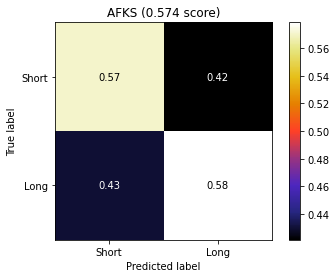

AFLT


100%|██████████| 249/249 [00:03<00:00, 76.74it/s]


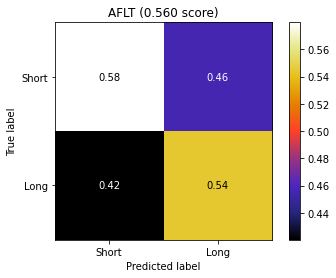

ALRS


100%|██████████| 249/249 [00:02<00:00, 94.52it/s] 


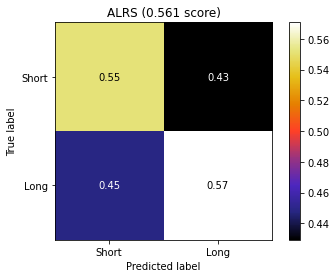

BANE


100%|██████████| 249/249 [00:02<00:00, 102.02it/s]


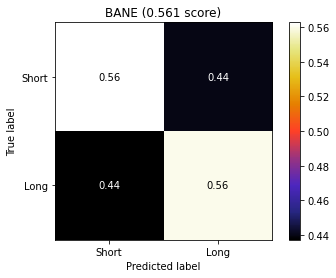

BANEP


100%|██████████| 249/249 [00:02<00:00, 102.74it/s]


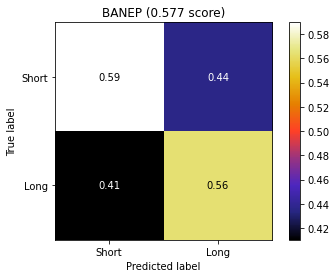

CHMF


100%|██████████| 249/249 [00:02<00:00, 102.09it/s]


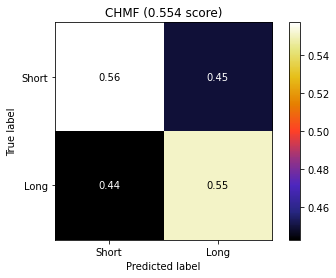

EONR


100%|██████████| 249/249 [00:02<00:00, 102.74it/s]


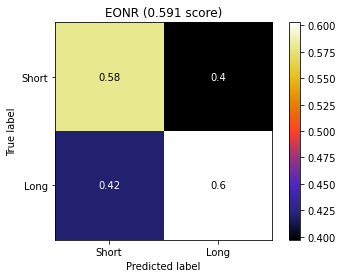

FEES


100%|██████████| 249/249 [00:02<00:00, 102.76it/s]


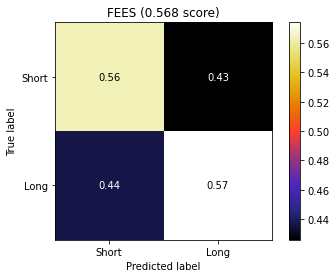

GAZP


100%|██████████| 249/249 [00:02<00:00, 99.54it/s] 


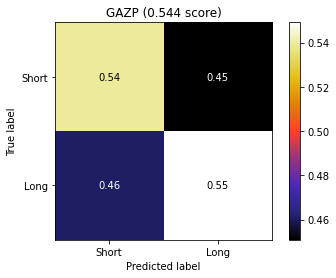

GMKN


100%|██████████| 249/249 [00:02<00:00, 98.33it/s] 


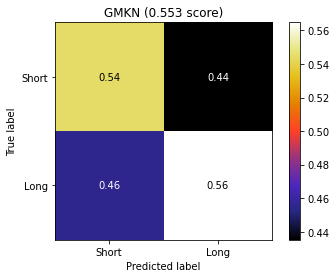

HYDR


100%|██████████| 249/249 [00:03<00:00, 75.70it/s] 


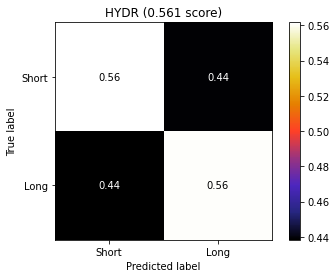

IRAO


100%|██████████| 249/249 [00:02<00:00, 100.81it/s]


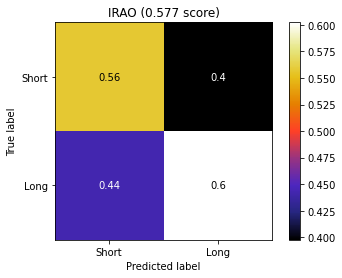

LKOH


100%|██████████| 249/249 [00:02<00:00, 100.18it/s]


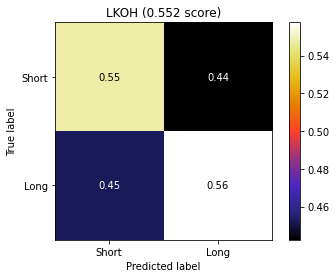

MAGN


100%|██████████| 249/249 [00:02<00:00, 91.53it/s] 


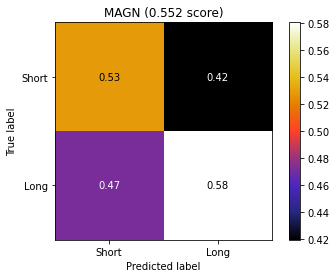

MGNT


100%|██████████| 249/249 [00:02<00:00, 100.20it/s]


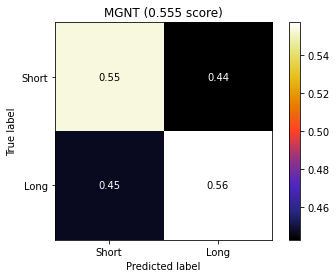

MOEX


100%|██████████| 249/249 [00:02<00:00, 101.47it/s]


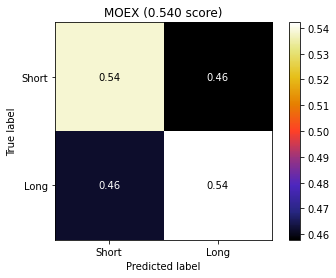

MTLR


100%|██████████| 249/249 [00:02<00:00, 98.32it/s] 


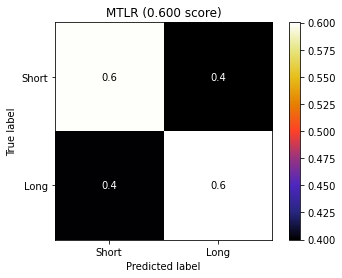

MTLRP


100%|██████████| 249/249 [00:02<00:00, 101.44it/s]


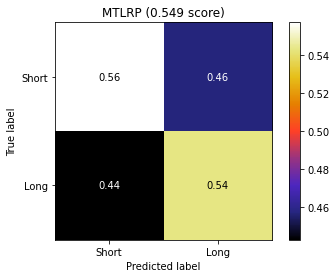

MTSS


100%|██████████| 249/249 [00:02<00:00, 100.80it/s]


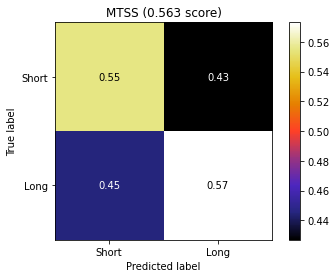

NLMK


100%|██████████| 249/249 [00:02<00:00, 100.79it/s]


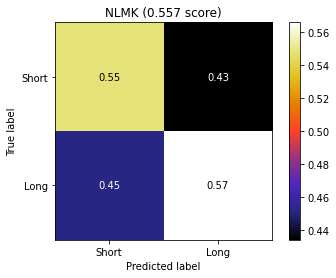

NVTK


100%|██████████| 249/249 [00:02<00:00, 101.44it/s]


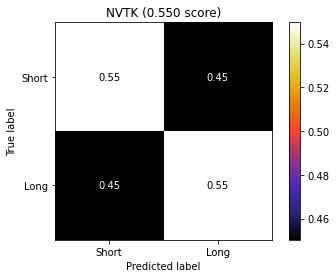

OGKB


100%|██████████| 249/249 [00:02<00:00, 102.09it/s]


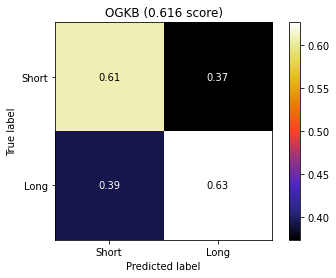

RASP


100%|██████████| 249/249 [00:02<00:00, 97.74it/s] 


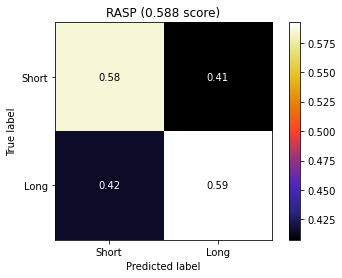

ROSN


100%|██████████| 249/249 [00:02<00:00, 100.24it/s]


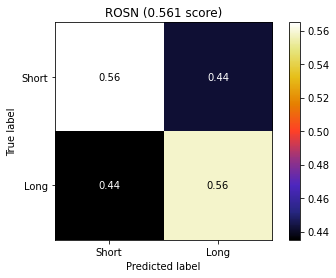

RSTI


100%|██████████| 249/249 [00:02<00:00, 100.78it/s]


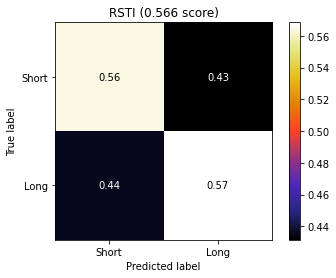

RTKM


100%|██████████| 249/249 [00:02<00:00, 100.77it/s]


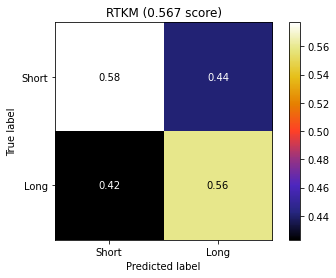

SBER


100%|██████████| 249/249 [00:02<00:00, 102.13it/s]


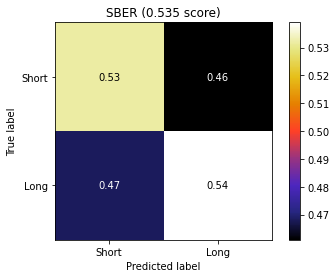

SBERP


100%|██████████| 249/249 [00:02<00:00, 92.54it/s] 


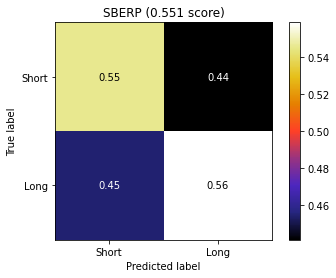

SIBN


100%|██████████| 249/249 [00:02<00:00, 102.76it/s]


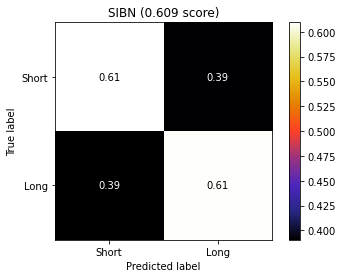

SNGS


100%|██████████| 249/249 [00:02<00:00, 100.19it/s]


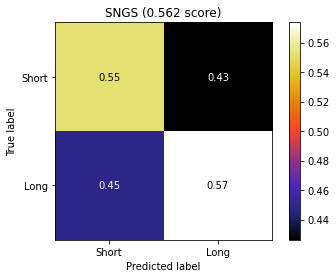

SNGSP


100%|██████████| 249/249 [00:02<00:00, 92.57it/s] 


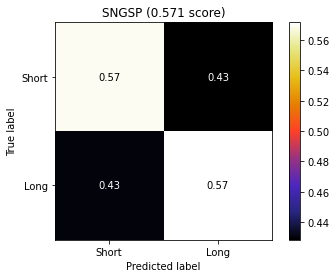

TAER


100%|██████████| 249/249 [00:02<00:00, 102.77it/s]


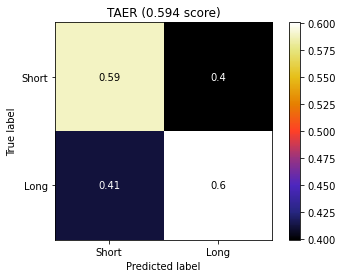

TATN


100%|██████████| 249/249 [00:02<00:00, 99.56it/s] 


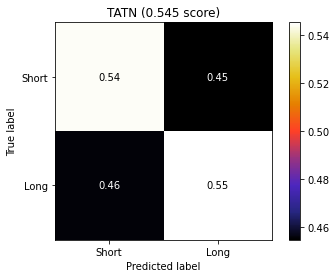

TRMK


100%|██████████| 249/249 [00:02<00:00, 101.46it/s]


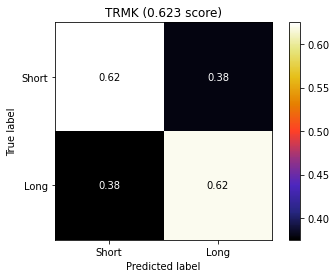

TRNFP


100%|██████████| 249/249 [00:02<00:00, 100.17it/s]


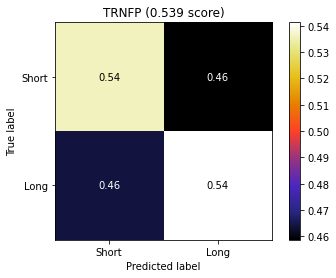

URKA


100%|██████████| 249/249 [00:02<00:00, 101.61it/s]


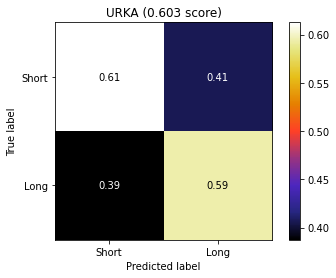

VTBR


100%|██████████| 249/249 [00:02<00:00, 97.74it/s] 


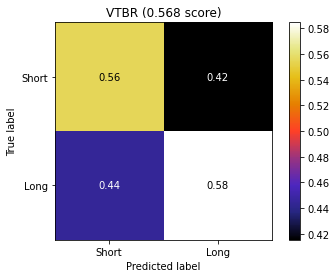

YNDX


100%|██████████| 249/249 [00:02<00:00, 101.46it/s]


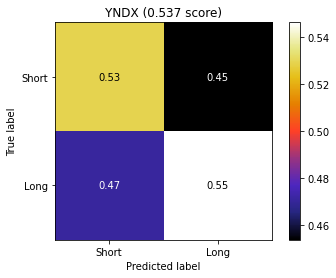

In [85]:
import os

tickers = [file.removesuffix(".txt") for file in os.listdir("../../analysis/data/tickers_trade_log") if file != "cache"]
for ticker in tickers:
    test_ticker(ticker)

In [4]:
import pickle
import numpy as np

with open("saved/SBER", "rb") as f:
    model = pickle.load(f)

In [13]:
rsi_values = pd.DataFrame({"rsi (4 length)": [50], "rsi (7 length)": [60], "rsi (14 length)": [70]})
print(model.predict(rsi_values))
print(model.predict_proba(rsi_values))

[-1]
[[0.51485004 0.48514996]]


In [14]:
type(model.predict(rsi_values))

numpy.ndarray